In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import ggplot
import seaborn as sns
import random
import xgboost as xgb
from scipy.stats import gaussian_kde
%matplotlib inline


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes an

# Table of Contents

1. Exploring the Data
2. Building a DataFrame and Standard Algorithm
3. Feature engineering/Feature Selection
4. Tuning the algorithm
5. Conclusions

## Exploring the Data


### Univariant Analysis

So lets take a first glance at what we have here:
    
- 6 files, all related by the key 'id'. Seems like we have to break down these relations first in order to get a coherent dataframe

After quickly scrolling through the data in MS Excel, i decided to do the following:
In order to just process numeric data, i dropped the strings from all the csv files containing the description ('event_type ', 'log_feature ', 'resource_type') manually with the replace function.



| id,event_type  	|   	
|:-:	|
|62093, ~~event_type~~ 15   	|





In [2]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

severity_type = pd.read_csv("Telstra/severity_type.csv")
severity_type_order = severity_type[['id']].drop_duplicates()
severity_type_order['order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)

print severity_type_order.shape

(18552, 2)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


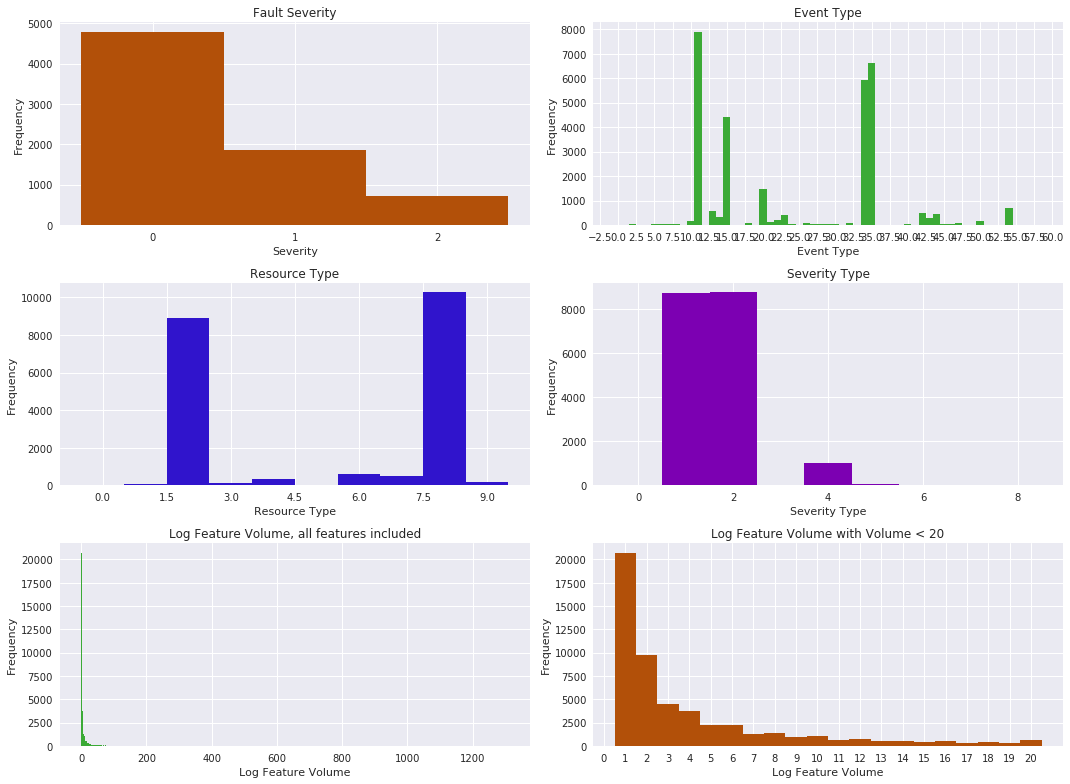

In [3]:
fig = plt.figure(figsize=(15,11))

###Fault Severity
ax1 = fig.add_subplot(321)
ax1.set_title('Fault Severity')
ax1.hist(train.fault_severity, bins=np.arange(4) - 0.5, color='#B25009')
ax1.set_xlabel('Severity')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(3))

### Event Type
ax2 = fig.add_subplot(322)
ax2.set_title('Event Type')
ax2.hist(events.event_type, bins=np.arange(60)-0.5,color='#3baa36')
ax2.set_xlabel('Event Type')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(60))
ax2.xaxis.set_major_locator(plt.MaxNLocator(30))


##Resource Type
ax3 = fig.add_subplot(323)
ax3.set_title('Resource Type')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Resource Type')
ax3.hist(resources.resource_type, bins=np.arange(11)-0.5, color = '#3014CC')
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))

#Severity Type
ax4 = fig.add_subplot(324)
ax4.set_title('Severity Type')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Severity Type')
ax4.hist(severity.severity_type, bins=np.arange(10)-0.5, color = '#7C00B2')

#Log Feature (All Datapoints)
ax5 = fig.add_subplot(325)
ax5.set_title('Log Feature Volume, all features included')
ax5.set_xlabel('Log Feature Volume')
ax5.set_ylabel('Frequency')
ax5.hist(log_feature.volume,bins=np.arange(log_feature.volume.min(), log_feature.volume.max()+1), align='left',color='#3baa36')

#Log Feature (All Datapoints)
ax6 = fig.add_subplot(326)
ax6.set_title('Log Feature Volume with Volume < 20')
ax6.set_xlabel('Log Feature Volume')
ax6.set_ylabel('Frequency')
ax6.set_xticks(range(21))
ax6.hist(log_feature.volume, bins=np.arange(log_feature.volume.min(), 22), align='left',color='#B25009')

#Display the figure
plt.tight_layout()
sns.plt.show()
fig.savefig('fig.png')

Our trainset shows the reports of 7381 incidents in total. Here is what i found out after graphing some of the data.


- As we can see, most of the interruptions are just a temporary network glitch ( *Fault Severity* = 0), but 1 and 2 do seem to cause problems quite frequently (around 35% of the time).

- The *event types* 11,35 and 34, 15 and 2 seem occur a lot together with a network incident ...


- The *resource types* 8 and 2 are used most. There is a significant gap between these two resources and the rest.

- The *severity type of warning messages* 1 and 2 seem to be the most frequent ones.

- The *log features* behave a little different here: We have a bunch of different features, which occur in a different Frequency (Volume). The two graphs above show just how often a given feature appears with an issue.
 Since the feature with the largest volume occurs 1350 times, the graph on the bottom left corner is highly skewed.


### Building a DataFrame and Standard Algorithm

Since the features are distributed over severall files and exist in a one-to-many fashion (one id can exist in N rows), its difficult to put them in. In order to do so, the data has to be merged together in one single dataframe. 

In [4]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

####### Saving labels
y = train.copy()
y = y.drop('location', axis=1)
y = y.drop('id', axis = 1)

###trainset with id & location
train = train.drop('fault_severity', axis = 1)

### Add Severity type and severity type order
severity_type_order = severity[['id']].drop_duplicates()
severity_type_order['severity_order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)
train = pd.merge(train, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
train = pd.merge(train, severity_type_order, how='inner', on='id')

### Add Resources
resources = pd.get_dummies(resources, columns=['resource_type'])
resources = resources.groupby(['id']).sum()
resources = resources.reset_index()
train = pd.merge(train, resources, on='id',how='left')


### Add Event Type
events = pd.get_dummies(events, columns=['event_type'])
events = events.groupby(['id']).sum()
events = events.reset_index()
train = pd.merge(train, events, on='id',how='left')


## volume-hot encoding & Appending the log_features to the trainset, order is preserved
log_feature = pd.get_dummies(log_feature, columns=['log_feature'])
volume =  log_feature['volume'].as_matrix()
volume = np.transpose(np.atleast_2d(volume))
only_features = log_feature.iloc[:,2:].as_matrix()
only_features = volume*only_features
log_feature_vhot = pd.DataFrame(only_features, index=log_feature.index)
log_feature_vhot.columns = log_feature.iloc[:,2:].columns
log_feature_vhot['id'] = pd.Series(log_feature['id'])

# move the column to head of list using index, pop and insert
cols = list(log_feature_vhot)
cols.insert(0, cols.pop(cols.index('id')))
log_feature_vhot = log_feature_vhot.loc[:, cols]

#merge vhot into log_feature
log_feature = log_feature_vhot.groupby(['id']).sum()
log_feature = log_feature.reset_index()
#pd.options.display.max_columns = 15
#print log_feature.head(5)

train = pd.merge(train, log_feature, on='id',how='left')



In [5]:
#train.to_csv(path_or_buf='Telstra/understand_train.csv',index=False)

We now have a 7381x453 train dataset, since 'resources', 'events' and 'log_features' are all one-hot-encoded.
Now that we have created our dataframe with all our features, lets run the xgboost algorithm with its initial configuration for the first time on it & see what happens.


In [40]:
#### general settings l
from xgboost import XGBClassifier
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
#define classifier, to tune only once
def xgboost_classif():
    return xgb.XGBClassifier(max_depth=5)
def random_xgboost_classif():
    childweight = random.choice(range(1,3))
    eta = 0.01*float(random.choice(range(1,4)))
    bytree = 0.01*float(random.choice(range(1,25)))
    md = random.choice(range(3,8))
    SS = 0.01*float(random.choice(range(1,9)))
    LAMBDA = random.choice([0, 0.1, 0.5])
    parameters = {'min_child_weight': childweight,
                  'learning_rate': eta,
                  'colsample_bytree': bytree,
                  'max_depth': md,
                  'subsample': SS,
                  'reg_lambda': LAMBDA,
                  'objective': 'multi:softprob',
                  'silent': 1,
                  }
    return parameters


def parse_xgb_cv_result(result):
    result_df = []
    result_df = result
    return result_df

model_1 = xgboost_classif()
model_1.fit(X_train, y_train.values.ravel())
print(model_1)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [7]:
## Show score
from sklearn.metrics import log_loss
y_pred = model_1.predict_proba(X_test)
print("Logloss: %.3f" % log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred))
#print("Logloss: %.3f" % log_loss(y_test,y_pred))

Logloss: 0.559


In [8]:
### Add Severity type,Resources, Event Type, log_features to test
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')

In [9]:
##Creating the final prediction data and submit it to kaggle.

test_pred = model_1.predict_proba(test)
final_pred = pd.DataFrame(test['id'])

result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

We scored a logloss of .5658% if we include ALL features (no feature engineering) and not further tune the parameters of our xgboost algorithm.

Our Kaggle score is 0.58768 with this very standard model, which would bring us to the 580th place on the leaderboard, if the competition was still on. Lets see if we can further improve our model.

## Feature engineering/Feature Selection
Luckily, xgboost provides a way to have a look on which features are the most predictive ones. In order to do so, we test our prediction with different threshholds, and see which one will get us the highest accuracy.

In [10]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_2 = xgboost_classif()
model_2.fit(X_train, y_train.values.ravel())

# Fit model using each importance as a threshold
thresholds = -np.sort(-model_2.feature_importances_,)
thresholds = np.unique(thresholds)


In [11]:
i = 0
for thresh in thresholds:
    if i<1:
        i+=1
        # select features using threshold
        selection = SelectFromModel(model_2, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = xgboost_classif()
        selection_model.fit(select_X_train, y_train.values.ravel())
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)
        #print y_pred
        #print y_test['fault_severity'].as_matrix(columns=None)
        loss = log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred)
        print("Thresh=%.5f, n=%d, Log_loss: %.4f" % (thresh, select_X_train.shape[1], loss))

Thresh=0.00000, n=453, Log_loss: 0.5593


When we run the outcommented code above, it suggests that we should use "Thresh=0.00022, n=133, Log_loss: 0.5657" to gain the maximum accuracy. So lets run our model and see how it goes.


In [12]:
##prepare the testset again
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')


###rerun initial model, use up all the data for training
model_3 = xgboost_classif()
model_3.fit(train, y.values.ravel())

## select features using threshold
selection = SelectFromModel(model_3, threshold=0.000215, prefit=True)
select_X_train = selection.transform(train)
## train model
selection_model = xgboost_classif()
selection_model.fit(select_X_train, y.values.ravel())
select_X_test_final = selection.transform(test)
y_pred_final = selection_model.predict_proba(select_X_test_final)

#create final dataframe
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = y_pred_final)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

Nice! I submitted the final_pred to kaggle, we improved our logloss down to .54026 on the public board. Time for some more research on this.
Since the data is now much more compact, i will have another look at it in MS Excel and see whethere i can up with any new ideas.

In [13]:
#Converting the new trainset (select_X_train) back to a pandas frame
select_X_train=pd.DataFrame(select_X_train)
labels = train.iloc[:, selection.get_support()]
select_train = pd.DataFrame(selection.transform(train), columns=labels.columns)
#select_train.to_csv(path_or_buf='Telstra/understand_select.csv',index=False)


In [14]:
##decided to test some random features
#parameters = random_xgboost_classif()
#dtrain = xgboost.DMatrix(train[list(train.columns)].values, label=train['fault_severity'].values, missing=-9999)

#dtrain = xgb.DMatrix( train, label=y)
#result = xgb.cv(parameters, dtrain, 350, nfold=10, metrics={'mlogloss'}, seed=0,verbose_eval= True, early_stopping_rounds= 5)
#print result
#result_df = parse_xgb_cv_result(result)
#print result_df


In [17]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

#train = pd.read_csv('train_modified.csv')
train['fault_severity'] = y
target = 'fault_severity'
IDcol = 'id'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5):
    # thanks to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    if useTrainCV: 
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain,num_boost_round=alg.get_params()['n_estimators'], verbose_eval = True, nfold=10, feval=evalerror, seed=0)
        alg.set_params(n_estimators=cvresult.shape[0])
        dtrain_fs = np.transpose(np.atleast_2d(dtrain['fault_severity'].values))
      
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['fault_severity'],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])
    dtrain_pred = np.transpose(np.atleast_2d(dtrain_predictions))
    #Print model report:
    print "\nModel Report"
    print "Logloss : %.4g" % log_loss(dtrain_fs,dtrain_predprob)

def evalerror(xtrain, labels):
    return 'mlogloss', log_loss(labels.get_label(),xtrain)

In [19]:
#n_estimators=1000,
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=488,  
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softprob',
 scale_pos_weight=1,
 )

modelfit(xgb1, train, predictors)


[0]	train-mlogloss:1.0331+0.000638257	test-mlogloss:1.03486+0.00181489
[1]	train-mlogloss:0.978823+0.0017174	test-mlogloss:0.982329+0.00363332
[2]	train-mlogloss:0.932723+0.00158854	test-mlogloss:0.938059+0.00423593
[3]	train-mlogloss:0.891665+0.00157322	test-mlogloss:0.898528+0.0051149
[4]	train-mlogloss:0.856056+0.0018691	test-mlogloss:0.864313+0.00577778
[5]	train-mlogloss:0.82489+0.00194933	test-mlogloss:0.83448+0.006319
[6]	train-mlogloss:0.796809+0.00184874	test-mlogloss:0.807954+0.00687753
[7]	train-mlogloss:0.772004+0.0019936	test-mlogloss:0.784466+0.00736575
[8]	train-mlogloss:0.74925+0.0015311	test-mlogloss:0.763344+0.00798497
[9]	train-mlogloss:0.729657+0.00144987	test-mlogloss:0.745321+0.00841799
[10]	train-mlogloss:0.711802+0.0016602	test-mlogloss:0.728764+0.00859549
[11]	train-mlogloss:0.695579+0.0019336	test-mlogloss:0.713823+0.00842928
[12]	train-mlogloss:0.680642+0.00227281	test-mlogloss:0.700074+0.00862986
[13]	train-mlogloss:0.666778+0.00215388	test-mlogloss:0.687361

[113]	train-mlogloss:0.426688+0.00238637	test-mlogloss:0.51965+0.0131799
[114]	train-mlogloss:0.425782+0.00241099	test-mlogloss:0.519457+0.0132716
[115]	train-mlogloss:0.425014+0.00229214	test-mlogloss:0.519289+0.0131226
[116]	train-mlogloss:0.42406+0.00234182	test-mlogloss:0.519092+0.0130533
[117]	train-mlogloss:0.423337+0.00233094	test-mlogloss:0.519027+0.0130652
[118]	train-mlogloss:0.422536+0.00215993	test-mlogloss:0.51888+0.0129398
[119]	train-mlogloss:0.421702+0.00218054	test-mlogloss:0.518635+0.0129766
[120]	train-mlogloss:0.420789+0.00223524	test-mlogloss:0.518413+0.01314
[121]	train-mlogloss:0.419855+0.00228606	test-mlogloss:0.518097+0.0131415
[122]	train-mlogloss:0.418999+0.00230278	test-mlogloss:0.517864+0.0131532
[123]	train-mlogloss:0.418145+0.00230808	test-mlogloss:0.517496+0.0131597
[124]	train-mlogloss:0.417396+0.00225393	test-mlogloss:0.51737+0.0131848
[125]	train-mlogloss:0.416598+0.00220409	test-mlogloss:0.517237+0.0131362
[126]	train-mlogloss:0.4156+0.00220009	test-

[225]	train-mlogloss:0.350592+0.00229902	test-mlogloss:0.504573+0.0133791
[226]	train-mlogloss:0.350063+0.0023644	test-mlogloss:0.504479+0.0134762
[227]	train-mlogloss:0.34947+0.00229371	test-mlogloss:0.504485+0.013524
[228]	train-mlogloss:0.348914+0.00233099	test-mlogloss:0.504563+0.0134605
[229]	train-mlogloss:0.348376+0.00232256	test-mlogloss:0.504584+0.0134314
[230]	train-mlogloss:0.347811+0.00234381	test-mlogloss:0.504475+0.0135456
[231]	train-mlogloss:0.347191+0.00232479	test-mlogloss:0.504393+0.0136705
[232]	train-mlogloss:0.346616+0.0023055	test-mlogloss:0.504409+0.0137069
[233]	train-mlogloss:0.345976+0.00228517	test-mlogloss:0.504259+0.0136666
[234]	train-mlogloss:0.345429+0.00228321	test-mlogloss:0.504228+0.0137828
[235]	train-mlogloss:0.344873+0.00228726	test-mlogloss:0.504102+0.0136747
[236]	train-mlogloss:0.344284+0.00226102	test-mlogloss:0.503943+0.0136485
[237]	train-mlogloss:0.343712+0.00217219	test-mlogloss:0.503943+0.0136048
[238]	train-mlogloss:0.343172+0.00222279	t

[337]	train-mlogloss:0.296045+0.00207842	test-mlogloss:0.501414+0.0135988
[338]	train-mlogloss:0.295593+0.00205333	test-mlogloss:0.501426+0.0135222
[339]	train-mlogloss:0.295212+0.00209263	test-mlogloss:0.501488+0.0136892
[340]	train-mlogloss:0.294791+0.00202434	test-mlogloss:0.501568+0.0137798
[341]	train-mlogloss:0.29437+0.00200199	test-mlogloss:0.5015+0.0139549
[342]	train-mlogloss:0.293906+0.00204465	test-mlogloss:0.501497+0.0139248
[343]	train-mlogloss:0.293463+0.00209622	test-mlogloss:0.501495+0.0139377
[344]	train-mlogloss:0.293015+0.00211906	test-mlogloss:0.501414+0.0140015
[345]	train-mlogloss:0.292552+0.0021707	test-mlogloss:0.501446+0.0141135
[346]	train-mlogloss:0.292162+0.0021401	test-mlogloss:0.50144+0.0141521
[347]	train-mlogloss:0.291767+0.00207501	test-mlogloss:0.501467+0.0141713
[348]	train-mlogloss:0.291401+0.00212361	test-mlogloss:0.501441+0.0141821
[349]	train-mlogloss:0.290998+0.00215228	test-mlogloss:0.501343+0.014137
[350]	train-mlogloss:0.290565+0.00214787	test

In [59]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=488, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27),verbose = 10, 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_



/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76507, std: 0.00112, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.76683, std: 0.00167, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.76169, std: 0.00347, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.77117, std: 0.00520, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.76711, std: 0.00541, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.76237, std: 0.00730, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.76507, std: 0.00328, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.76263, std: 0.00496, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.76142, std: 0.00546, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.76318, std: 0.00569, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.76142, std: 0.00979, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.75844, std: 0.00738, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [ ]:
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')

test_pred = xgb1.predict_proba(test)
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)